In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from perceptually_important import find_pips

In [22]:
class PIPPatternMiner:

    def __init__(self, n_pips: int, lookback: int, hold_period: int):
        self._n_pips = n_pips
        self._lookback = lookback
        self._hold_period = hold_period
        
        self._unique_pip_patterns = []
        self._unique_pip_indices = []
        self._cluster_centers = []
        self._pip_clusters = []

        self._cluster_signals = []
        self._cluster_objs = []

        self._long_signal = None
        self._short_signal = None

        self._selected_long = []
        self._selected_short = []

        self._fit_martin = None
        self._perm_martins = []
        
        self._data = None # Array of log closing prices to mine patterns
        self._returns = None # Array of next log returns, concurrent with _data

    def get_fit_martin(self):
        return self._fit_martin

    def get_permutation_martins(self):
        return self._perm_martins
    
    
        # Add this method to the PIPPatternMiner class
    def plot_best_performer_patterns(self, candle_data: pd.DataFrame):
        plt.style.use('dark_background')
    
        fig, (ax_long, ax_short) = plt.subplots(2, 1, figsize=(10, 8))

        # Plot best long pattern
        best_long_pattern_idx = self._unique_pip_indices[self._selected_long[0]]
        data_slice_long = candle_data.iloc[best_long_pattern_idx - self._lookback + 1: best_long_pattern_idx + 1]
        idx_long = data_slice_long.index
        plot_pip_x_long, plot_pip_y_long = find_pips(data_slice_long['close'].to_numpy(), self._n_pips, 3)

        pip_lines_long = []
        colors_long = []
        for line_i_long in range(self._n_pips - 1):
            l0_long = [(idx_long[plot_pip_x_long[line_i_long]], plot_pip_y_long[line_i_long]),
                    (idx_long[plot_pip_x_long[line_i_long + 1]], plot_pip_y_long[line_i_long + 1])]
            pip_lines_long.append(l0_long)
            colors_long.append('w')

        mpf.plot(data_slice_long, type='candle', alines=dict(alines=pip_lines_long, colors=colors_long),
                ax=ax_long, style='charles', update_width_config=dict(candle_linewidth=1.75))
        ax_long.set_title("Best Long Pattern")

        # Plot best short pattern
        best_short_pattern_idx = self._unique_pip_indices[self._selected_short[0]]
        data_slice_short = candle_data.iloc[best_short_pattern_idx - self._lookback + 1: best_short_pattern_idx + 1]
        idx_short = data_slice_short.index
        plot_pip_x_short, plot_pip_y_short = find_pips(data_slice_short['close'].to_numpy(), self._n_pips, 3)

        pip_lines_short = []
        colors_short = []
        for line_i_short in range(self._n_pips - 1):
            l0_short = [(idx_short[plot_pip_x_short[line_i_short]], plot_pip_y_short[line_i_short]),
                        (idx_short[plot_pip_x_short[line_i_short + 1]], plot_pip_y_short[line_i_short + 1])]
            pip_lines_short.append(l0_short)
            colors_short.append('w')

        mpf.plot(data_slice_short, type='candle', alines=dict(alines=pip_lines_short, colors=colors_short),
                ax=ax_short, style='charles', update_width_config=dict(candle_linewidth=1.75))
        ax_short.set_title("Best Short Pattern")

        plt.tight_layout()
        plt.show()
        

    def plot_cluster_examples(self, candle_data: pd.DataFrame, cluster_i: int, grid_size: int = 5):
        plt.style.use('dark_background')
        fig, axs = plt.subplots(grid_size, grid_size)
        flat_axs = axs.flatten()
        for i in range(len(flat_axs)):
            if i >= len(self._pip_clusters[cluster_i]):
                break
            
            pat_i = self._unique_pip_indices[self._pip_clusters[cluster_i][i]]
            data_slice = candle_data.iloc[pat_i - self._lookback + 1: pat_i + 1]
            idx = data_slice.index
            plot_pip_x, plot_pip_y = find_pips(data_slice['close'].to_numpy(), self._n_pips, 3)
            
            pip_lines = []
            colors = []
            for line_i in range(self._n_pips - 1):
                l0 = [(idx[plot_pip_x[line_i]], plot_pip_y[line_i]), (idx[plot_pip_x[line_i + 1]], plot_pip_y[line_i + 1])]
                pip_lines.append(l0)
                colors.append('w')

            mpf.plot(data_slice, type='candle',alines=dict(alines=pip_lines, colors=colors), ax=flat_axs[i], style='charles', update_width_config=dict(candle_linewidth=1.75) )
            flat_axs[i].set_yticklabels([])
            flat_axs[i].set_xticklabels([])
            flat_axs[i].set_xticks([])
            flat_axs[i].set_yticks([])
            flat_axs[i].set_ylabel("")

        fig.suptitle(f"Cluster {cluster_i}", fontsize=32)
        plt.show()


    def predict(self, pips_y: list):
        norm_y = (np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y)

        # Find cluster
        best_dist = 1.e30
        best_clust = -1
        for clust_i in range(len(self._cluster_centers)):
            center = np.array(self._cluster_centers[clust_i])
            dist = np.linalg.norm(norm_y-center)
            if dist < best_dist:
                best_dist = dist
                best_clust = clust_i

        if best_clust in self._selected_long:
            return 1.0
        elif best_clust in self._selected_short:
            return -1.0
        else:
            return 0.0
    
    
    def train(self, arr: np.array, n_reps=-1):
        self._data = arr
        self._returns = pd.Series(arr).diff().shift(-1)
        self._find_unique_patterns()
        

        search_instance = silhouette_ksearch(
                self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
        
        amount = search_instance.get_amount()
        self._kmeans_cluster_patterns(amount)

        self._get_cluster_signals()
        self._assign_clusters()
        self._fit_martin = self._get_total_performance()
        
        print(self._fit_martin)

        if n_reps <= 1:
            return

        # Start monte carlo permutation test
        data_copy = self._data.copy()
        returns_copy = self._returns.copy()
        
        for rep in range(1, n_reps):
            x = np.diff(data_copy).copy()
            np.random.shuffle(x)
            x = np.concatenate([np.array([data_copy[0]]), x])
            self._data = np.cumsum(x)
            self._returns = pd.Series(self._data).diff().shift(-1)
            print("rep", rep) 
            self._find_unique_patterns()
            search_instance = silhouette_ksearch(
                    self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
            amount = search_instance.get_amount()
            self._kmeans_cluster_patterns(amount)
            self._get_cluster_signals()
            self._assign_clusters()
            perm_martin = self._get_total_performance()
            self._perm_martins.append(perm_martin)


    def _find_unique_patterns(self):
        # Find unique pip patterns in data
        self._unique_pip_indices.clear()
        self._unique_pip_patterns.clear()
        
        last_pips_x = [0] * self._n_pips
        for i in range(self._lookback - 1, len(self._data) - self._hold_period):
            start_i = i - self._lookback + 1
            window = self._data[start_i: i + 1]
            pips_x, pips_y = find_pips(window, self._n_pips, 3)
            pips_x = [j + start_i for j in pips_x]

            # Check internal pips to see if it is the same as last
            same = True
            for j in range(1, self._n_pips - 1):
                if pips_x[j] != last_pips_x[j]:
                    same = False
                    break
            
            if not same:
                # Z-Score normalize pattern
                pips_y = list((np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y))
                self._unique_pip_patterns.append(pips_y)
                self._unique_pip_indices.append(i)

            last_pips_x = pips_x


    def _kmeans_cluster_patterns(self, amount_clusters):
        # Cluster Patterns
        initial_centers = kmeans_plusplus_initializer(self._unique_pip_patterns, amount_clusters).initialize()
        kmeans_instance = kmeans(self._unique_pip_patterns, initial_centers)
        kmeans_instance.process()

        # Extract clustering results: clusters and their centers
        self._pip_clusters = kmeans_instance.get_clusters()
        self._cluster_centers = kmeans_instance.get_centers()

    def _get_martin(self, rets: np.array):
        rsum = np.sum(rets)
        short = False
        if rsum < 0.0:
            rets *= -1
            rsum *= -1
            short = True

        csum = np.cumsum(rets)
        eq = pd.Series(np.exp(csum))
        sumsq = np.sum( ((eq / eq.cummax()) - 1) ** 2.0 )
        ulcer_index = (sumsq / len(rets)) ** 0.5
        martin = rsum / ulcer_index
        if short:
            martin = -martin

        return martin

    def _get_cluster_signals(self):
        self._cluster_signals.clear()

        for clust in self._pip_clusters: # Loop through each cluster
            signal = np.zeros(len(self._data))
            for mem in clust: # Loop through each member in cluster
                arr_i = self._unique_pip_indices[mem]
                
                # Fill signal with 1s following pattern identification
                # for hold period specified
                signal[arr_i: arr_i + self._hold_period] = 1. 
            
            self._cluster_signals.append(signal)

    def _assign_clusters(self):
        self._selected_long.clear()
        self._selected_short.clear()
        
        # Assign clusters to long/short/neutral
        cluster_martins = []
        for clust_i in range(len(self._pip_clusters)): # Loop through each cluster
            sig = self._cluster_signals[clust_i]
            sig_ret = self._returns * sig
            martin = self._get_martin(sig_ret)
            cluster_martins.append(martin)

        best_long = np.argmax(cluster_martins)
        best_short = np.argmin(cluster_martins)
        self._selected_long.append(best_long)
        self._selected_short.append(best_short)

    # Add these two methods to the PIPPatternMiner class

    def plot_best_long_pattern(self, candle_data: pd.DataFrame):
        best_long_cluster = self._selected_long[0]
        self.plot_cluster_examples(candle_data, best_long_cluster)

    def plot_best_short_pattern(self, candle_data: pd.DataFrame):
        best_short_cluster = self._selected_short[0]
        self.plot_cluster_examples(candle_data, best_short_cluster)
    

    def _get_total_performance(self):

        long_signal = np.zeros(len(self._data))
        short_signal = np.zeros(len(self._data))

        for clust_i in range(len(self._pip_clusters)):
            if clust_i in self._selected_long:
                long_signal += self._cluster_signals[clust_i]
            elif clust_i in self._selected_short:
                short_signal += self._cluster_signals[clust_i]
        
        long_signal /= len(self._selected_long)
        short_signal /= len(self._selected_short)
        short_signal *= -1

        self._long_signal = long_signal
        self._short_signal = short_signal
        rets = (long_signal + short_signal) * self._returns

        martin = self._get_martin(rets)
        return martin


In [23]:
data = pd.read_csv('BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = np.log(data)



data = data[data.index < '01-01-2020']
arr = data['close'].to_numpy()
pip_miner = PIPPatternMiner(n_pips=5, lookback=24, hold_period=6)

In [32]:
pip_miner.train(arr, n_reps=4)

31.803764907681053
rep 1
rep 2
rep 3


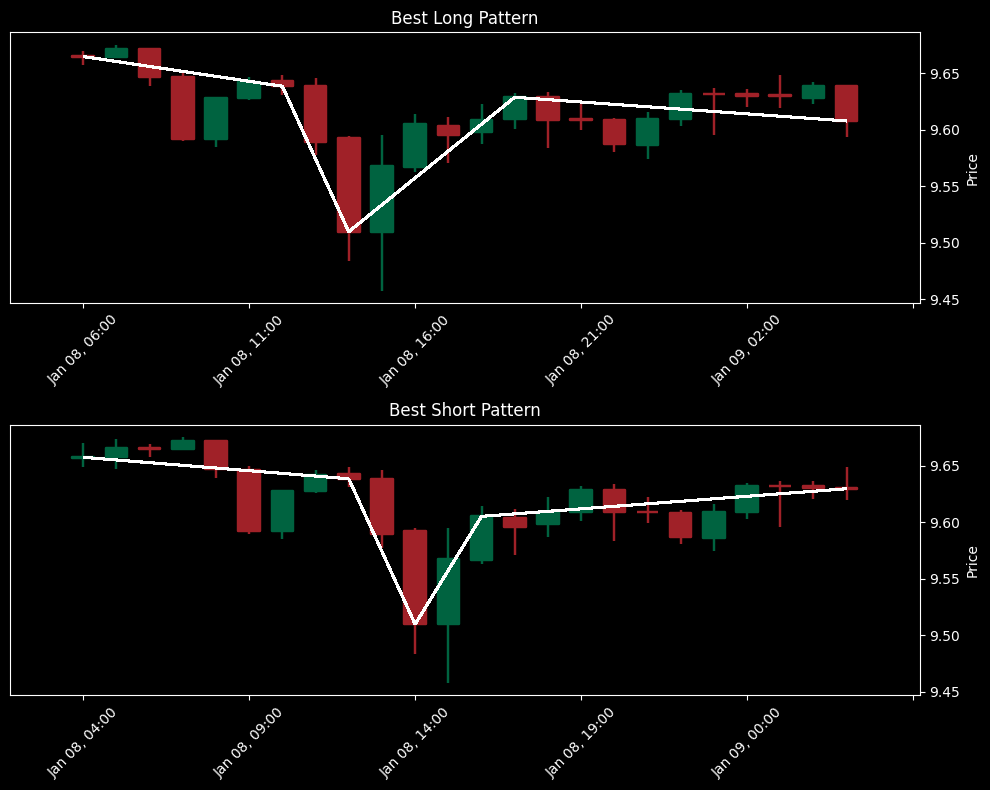

In [33]:
pip_miner.plot_best_performer_patterns(data)

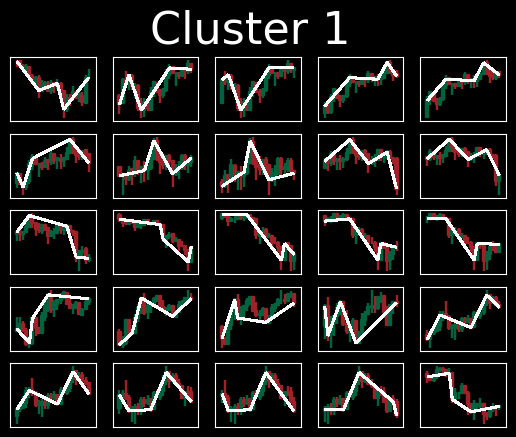

In [34]:

# Visualize best performing long pattern
#pip_miner.plot_best_long_pattern(data)

# Visualize best performing short pattern
pip_miner.plot_best_short_pattern(data)

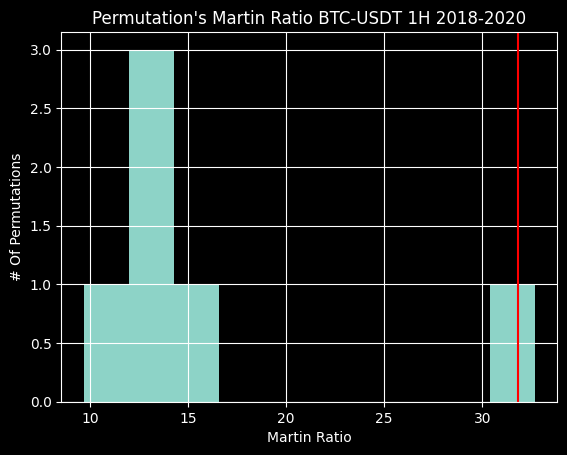

In [35]:
plt.style.use('dark_background')
actual_martin = pip_miner.get_fit_martin()
perm_martins = pip_miner.get_permutation_martins()
ax = pd.Series(perm_martins).hist()
ax.set_ylabel("# Of Permutations")
ax.set_xlabel("Martin Ratio")
ax.set_title("Permutation's Martin Ratio BTC-USDT 1H 2018-2020")
ax.axvline(actual_martin, color='red')